In [253]:
conda install seaborn

/bin/bash: /home/alon/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/alon/anaconda3/envs/autogluon

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seaborn-0.13.2             |   py39h06a4308_0         594 KB
    ------------------------------------------------------------
                                           Total:         594 KB

The following NEW packages will be INSTALLED:

  seaborn            pkgs/main/linux-64::seaborn-0.13.2-py39h06a4308_0



seaborn-0.13.2       | 594 KB    | ##################################### | 100% 
Preparing 

In [10]:
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
#from autogluon.tabular import TabularDataset, TabularPredictor
#from xgboost import XGBClassifier
#from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import KernelPCA


In [11]:
train = pd.read_excel('/mnt/d/SCIS/train.xlsx')
test = pd.read_excel('/mnt/d/SCIS/test.xlsx')

In [12]:
import pandas as pd
from scipy.stats import zscore

# Assuming `df` is your original DataFrame
def z_score_normalize_except_first_two(df):
    # Select the first two columns (unchanged)
    df_first_two = df.iloc[:, :2]
    
    # Select the rest of the columns to normalize
    df_to_normalize = df.iloc[:, 2:]
    
    # Apply Z-score normalization
    df_normalized = df_to_normalize.apply(zscore)
    
    # Recombine the first two columns with the normalized columns
    df_final = pd.concat([df_first_two, df_normalized], axis=1)
    
    return df_final

In [13]:
train_normalized = z_score_normalize_except_first_two(train)
test_normalized = z_score_normalize_except_first_two(test)

In [14]:
def drop_nans(df, axis=1):
    """
    Drops columns or rows with any NaN values from the DataFrame.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - axis (int): 1 to drop columns with NaN values, 0 to drop rows with NaN values.

    Returns:
    - pandas.DataFrame: A DataFrame with NaN values removed (either columns or rows).
    """
    df_clean = df.dropna(axis=axis)
    return df_clean

# Example usage:
# To drop columns with NaN values:
# df_clean = drop_nans(df, axis=1)

# To drop rows with NaN values:
# df_clean = drop_nans(df, axis=0)

In [15]:
train_normalized = drop_nans(train_normalized)
test_normalized = drop_nans(test_normalized)

In [16]:
train_normalized.to_csv('/mnt/d/SCIS/train_normalized.csv', index = False)
test_normalized.to_csv('/mnt/d/SCIS/test_normalized.csv', index = False)

In [17]:
def perform_pca(df, n_components=None):
    # Drop the first two columns if needed, as PCA works on numeric data
    df_for_pca = df.iloc[:, 2:]  # Exclude first two columns if they aren't part of the analysis
    
    # Initialize PCA object
    pca = PCA(n_components=n_components)
    
    # Fit and transform the data
    principal_components = pca.fit_transform(df_for_pca)
    
    # Create a new DataFrame with the principal components
    pca_columns = [f'PC{i+1}' for i in range(principal_components.shape[1])]
    df_pca = pd.DataFrame(principal_components, columns=pca_columns)
    
    # Optionally, you can concatenate the first two columns back if needed
    df_final = pd.concat([df.iloc[:, :2], df_pca], axis=1)
    
    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    
    return df_final, explained_variance

In [26]:
def apply_pca_to_test(df_test, kpca):
    # Apply the PCA model to the test set
    df_for_pca_test = df_test.iloc[:, 2:]  # Exclude first two columns as before
    
    # Transform the test data using the PCA model fitted on the training data
    principal_components_test = kpca.transform(df_for_pca_test)
    
    # Create a DataFrame with the principal components for the test set
    pca_columns = [f'PC{i+1}' for i in range(principal_components_test.shape[1])]
    df_pca_test = pd.DataFrame(principal_components_test, columns=pca_columns)
    
    # Optionally, concatenate the first two columns back from the test set
    df_final_test = pd.concat([df_test.iloc[:, :2], df_pca_test], axis=1)
    
    return df_final_test

In [25]:
# Add the missing columns to the test set, filling with 0 or NaN
test_normalized = test_normalized.reindex(columns=train_normalized.columns, fill_value=0)

# Now you can apply the same PCA transformation to the test set
df_test_pca = apply_pca_to_test(test_normalized, pca_model)

NameError: name 'pca_model' is not defined

In [27]:
df_train_pca, pca_model = perform_pca(train_normalized, n_components=100)
# Apply the same PCA model to the test set
df_test_pca = apply_pca_to_test(test_normalized, pca_model)

ValueError: n_components=100 must be between 0 and min(n_samples, n_features)=89 with svd_solver='full'

In [28]:
df_train_pca.iloc[:, 1] = df_train_pca.iloc[:, 1].astype('category')
df_test_pca.iloc[:, 1] = df_test_pca.iloc[:, 1].astype('category')

NameError: name 'df_train_pca' is not defined

In [29]:
df_test_pca.dtypes

NameError: name 'df_test_pca' is not defined

In [30]:
print(explained_variance)

NameError: name 'explained_variance' is not defined

In [239]:
import numpy as np
np.sum(explained_variance[:30])

0.9456371976546977

In [240]:
def get_first_k_pcs(df_pca, explained_variance, k):
    """
    Function to return a DataFrame containing the first k principal components 
    from the output of the perform_pca function.

    Parameters:
    - df_pca: DataFrame containing principal components and possibly other columns.
    - explained_variance: The explained variance array (not used directly in this function but can be informative).
    - k: The number of principal components to retain.

    Returns:
    - DataFrame with the first k principal components.
    """
    # Assume the first two columns are from the original data, so start slicing from the third column onward
    pca_columns = df_pca.columns[2:]  # Exclude first two columns if needed
    
    # Extract only the first k principal components
    df_pca_k = df_pca.iloc[:, :k + 2]  # Include first two columns and k components
    
    return df_pca_k

In [241]:
#################### for KPCA

train_pcs = df_train_pca
test_pcs = df_test_pca

In [242]:
train_pcs = get_first_k_pcs(df_train_pca, explained_variance, 80)
test_pcs = get_first_k_pcs(df_test_pca, explained_variance,80)

In [246]:
test_pcs

,sample,outcome,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80
0,1,prog,-0.210144,-0.379498,-0.164761,0.380265,-0.194996,0.065255,0.021855,0.093018,...,-0.014004,0.002350,-0.014399,-0.004794,0.000357,-0.009002,-0.014628,0.019665,0.008356,0.004118
1,3,prog,0.101870,-0.417373,0.169850,0.002323,0.114836,0.165995,-0.056323,-0.114937,...,-0.004233,-0.012824,-0.000574,-0.030341,-0.041900,-0.020487,0.003722,0.010515,-0.001875,-0.001925
2,6,prog,-0.399082,0.286951,-0.165185,0.105278,0.374074,0.021288,-0.007201,-0.022236,...,-0.006515,-0.013326,0.001128,0.005475,-0.010363,-0.021934,0.010879,-0.014949,0.006365,-0.015352
3,16,prog,-0.343102,-0.096963,-0.172757,0.097527,-0.132189,-0.054948,0.063807,0.098278,...,0.011329,-0.003172,-0.018593,0.006769,0.006372,-0.010666,-0.015219,0.003204,-0.009838,-0.002976
4,38,reg,0.310400,-0.089095,-0.208523,-0.029837,-0.009807,-0.134903,0.054438,0.013609,...,0.036145,-0.024602,-0.067967,-0.005182,0.059066,-0.017805,0.003804,-0.040164,0.060294,0.064398
5,46,reg,-0.014775,0.394010,-0.061212,-0.070731,-0.051265,0.228876,-0.063372,0.191222,...,-0.012676,-0.018631,0.016807,-0.039577,0.023766,-0.009336,0.023071,-0.008190,-0.017580,-0.008621
6,53,prog,0.346789,0.092646,-0.369553,-0.138971,-0.093600,-0.012336,-0.134078,-0.071570,...,0.030115,-0.003534,-0.001884,-0.007178,-0.030735,0.001021,-0.054582,-0.019571,0.005355,0.003950
7,57,reg,-0.439204,-0.118872,0.037962,-0.294174,-0.046675,0.020018,-0.003531,-0.094005,...,0.003891,-0.002620,-0.017071,-0.006291,-0.001358,0.002684,0.007630,0.010747,-0.003270,-0.007753
8,69,prog,0.360781,-0.237494,-0.335886,-0.025867,0.040011,-0.069914,0.001589,0.012056,...,-0.001278,-0.001007,0.009247,0.021648,0.013133,-0.000286,0.015664,-0.047717,0.008425,0.029049
9,74,reg,-0.115652,0.405380,0.256557,0.060264,0.059852,0.010863,0.031875,0.011775,...,0.003713,0.002053,0.006483,0.005508,-0.028262,-0.005788,-0.027639,0.006091,-0.016133,0.011316


In [5]:
import matplotlib.pyplot as plt

def plot_explained_variance(explained_variance):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.savefig('/mnt/d/SCIS/scree', format='tiff', dpi=330)
    plt.show()
    
    
# Example usage:
plot_explained_variance(explained_variance)

NameError: name 'explained_variance' is not defined

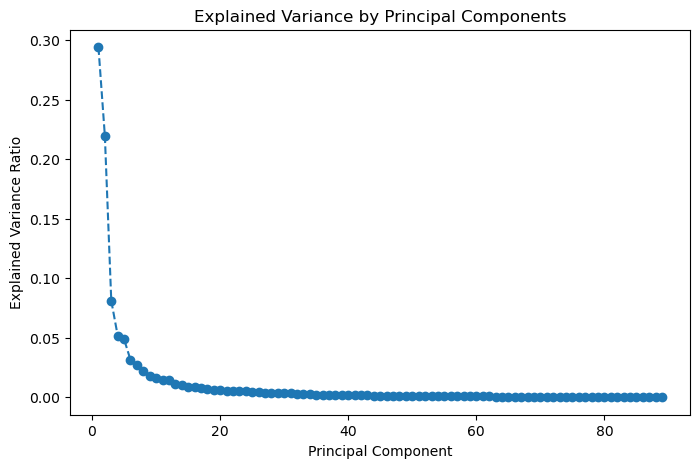

In [244]:
plot_explained_variance(explained_variance)

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Encode the categorical labels
label_encoder = LabelEncoder()

# Fit the label encoder on the training set and transform the labels
y_train = label_encoder.fit_transform(train_pcs['outcome'])  # Train labels encoded

# Apply the same encoding to the test set (use the same encoder)
y_test = label_encoder.transform(test_pcs['outcome'])  # Test labels encoded

# Drop the 'outcome' column from the feature sets
X_train = train_pcs.drop(columns='outcome')
X_test = test_pcs.drop(columns='outcome')

# Initialize the Logistic Regression model with class balancing
log_reg = RidgeClassifier()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Different solvers for Logistic Regression
}

# Initialize GridSearchCV with the logistic regression model
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, 
                           scoring='f1', cv=10, verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_log_reg = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_log_reg.predict(X_test)

# Make predictions on the test data to get the predicted probabilities
y_scores = best_log_reg.decision_function(X_test)  # Probability of the positive class

# Evaluate the model using accuracy and AUC
accuracy = accuracy_score(y_test, y_pred)




print(f"Best parameters from GridSearch: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))



Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameters from GridSearch: {'alpha': 0.1}
Accuracy: 0.7895

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.83      0.62      0.71         8

    accuracy                           0.79        19
   macro avg       0.80      0.77      0.77        19
weighted avg       0.80      0.79      0.78        19



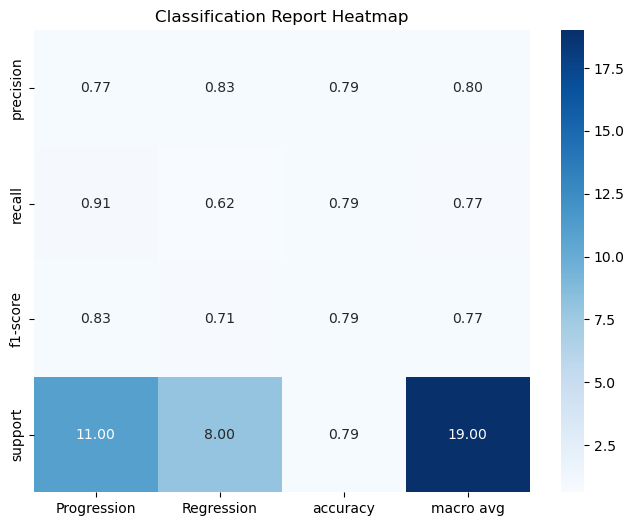

In [263]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Generate the classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to a DataFrame
report_df = pd.DataFrame(report).transpose()
report_df.rename(index={'0': 'Progression', '1': 'Regression'}, inplace=True)

# Plot the classification report as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.savefig('/mnt/d/SCIS/classification_report.jpg', format ='jpeg', dpi = 300)
plt.show()

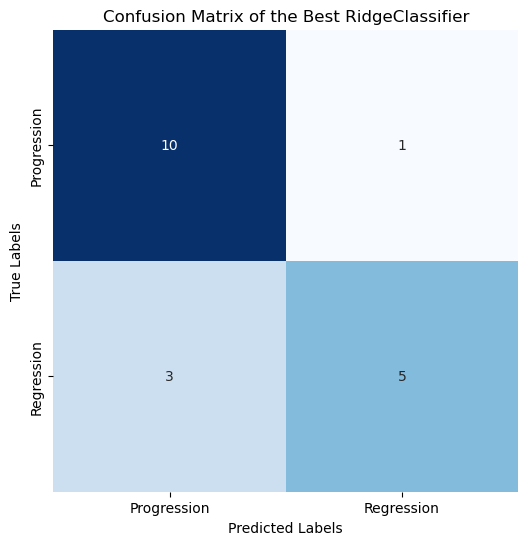

In [264]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Progression', 'Regression'])  # For predicted labels
plt.yticks([0.5, 1.5], ['Progression', 'Regression'])  # For true labels
plt.title('Confusion Matrix of the Best RidgeClassifier')
plt.savefig('/mnt/d/SCIS/confusion_pathomics.jpg', format ='jpeg', dpi = 300)
plt.show()


In [ ]:
log_reg.decision_function()

In [65]:
label_encoder.classes_

array(['prog', 'reg'], dtype=object)

In [71]:
y_pred_proba = best_log_reg.predict_proba(X_test)
print(y_pred_proba)
print(test_pcs['sample'])

[[0.8369334  0.1630666 ]
 [0.77149229 0.22850771]
 [0.22331044 0.77668956]
 [0.82285231 0.17714769]
 [0.70699674 0.29300326]
 [0.42782471 0.57217529]
 [0.60108375 0.39891625]
 [0.62856691 0.37143309]
 [0.70209935 0.29790065]
 [0.41488109 0.58511891]
 [0.5912577  0.4087423 ]
 [0.58118214 0.41881786]
 [0.56287175 0.43712825]
 [0.11317263 0.88682737]
 [0.28498351 0.71501649]
 [0.56092602 0.43907398]
 [0.3503446  0.6496554 ]
 [0.47240835 0.52759165]
 [0.37160253 0.62839747]]
0       1
1       3
2       6
3      16
4      38
5      46
6      53
7      57
8      69
9      74
10     80
11     86
12     97
13    134
14    140
15    145
16    148
17    150
18    165
Name: sample, dtype: int64


In [ ]:
y_pred

In [121]:
train_data = TabularDataset(train_pcs)

In [122]:
predictor = TabularPredictor(label='outcome', eval_metric='f1').fit(train_data,
                                                                   num_bag_folds = 8, num_bag_sets = 8, auto_stack = True, num_stack_levels = 3)

No path specified. Models will be saved in: "AutogluonModels/ag-20240918_143800/"
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=8, num_bag_sets=8
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240918_143800/"
AutoGluon Version:  0.6.2
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Apr 2 22:23:49 UTC 2021
Train Data Rows:    89
Train Data Columns: 81
Label Column: outcome
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  ['prog', 'reg']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = reg, class 0 = prog
	Note: For your binary classification, AutoGluon arbitrarily sel

Fitting model: LightGBM_BAG_L1 ...
2024-09-18 17:38:02,606	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:38:02,610	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:38:02,611	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:38:02,614	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:38:02,615	ERROR worker.py:399 -- Unhandled 

Fitting model: RandomForestGini_BAG_L1 ...
2024-09-18 17:38:05,021	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:38:05,024	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:38:05,026	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:38:05,028	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:38:05,030	ERROR worker.py:399 -- Un

Fitting model: WeightedEnsemble_L2 ...
2024-09-18 17:39:43,484	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:39:43,487	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:39:43,495	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:39:43,496	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:39:43,497	ERROR worker.py:399 -- Unhand

Fitting model: LightGBM_BAG_L2 ...
	Fitting 64 child models (S1F1 - S8F8) | Fitting with ParallelLocalFoldFittingStrategy
[2024-09-18 17:39:49,209 E 31863 365] direct_task_transport.cc:715: Attempt to cancel task 653836cad50a2fd5ffffffffffffffffffffffff01000000 in a worker that doesn't have this task.
		ray::_ray_fit() (pid=7539, ip=172.26.12.215)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/tabular/models/lgb/lgb_model.py", line 82, in _fit
    try_import_lightgbm()  # raise helpful error message if LightGBM isn't installed
  File "/home/alon/anaconda3/envs/a

2024-09-18 17:39:49,222	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:39:49,223	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
Fitting model: RandomForestGini_BAG_L2 ...
2024-09-18 17:39:49,227	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:39:49,228	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:39:49,229	ERROR worker.py:399 -- Un

Detailed Traceback:
Traceback (most recent call last):
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1422, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, total_resources=total_resources, **model_fit_kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1367, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, total_resources=total_resources, **model_fit_kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/ensemble/stacker_ensemble_model.py", line 154, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "/home/alon/anaconda3/envs/autogluon/l

Detailed Traceback:
Traceback (most recent call last):
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1422, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, total_resources=total_resources, **model_fit_kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1367, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, total_resources=total_resources, **model_fit_kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/ensemble/stacker_ensemble_model.py", line 154, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "/home/alon/anaconda3/envs/autogluon/l

2024-09-18 17:41:43,304	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:41:43,305	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:41:43,306	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:41:43,307	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:41:43,308	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UN

Detailed Traceback:
Traceback (most recent call last):
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1422, in _train_and_save
    model = self._train_single(X, y, model, X_val, y_val, total_resources=total_resources, **model_fit_kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/trainer/abstract_trainer.py", line 1367, in _train_single
    model = model.fit(X=X, y=y, X_val=X_val, y_val=y_val, total_resources=total_resources, **model_fit_kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/ensemble/stacker_ensemble_model.py", line 154, in _fit
    return super()._fit(X=X, y=y, time_limit=time_limit, **kwargs)
  File "/home/alon/anaconda3/envs/autogluon/l

2024-09-18 17:43:30,827	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:43:30,828	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:43:30,830	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:43:30,830	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
	0.6933	 = Validation score   (f1)
	1.62s	 = Training   runtime
	0.0s	 = Validation runtime


		ray::_ray_fit() (pid=28665, ip=172.26.12.215)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 374, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold,
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/models/abstract/abstract_model.py", line 703, in fit
    out = self._fit(**kwargs)
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/tabular/models/lgb/lgb_model.py", line 82, in _fit
    try_import_lightgbm()  # raise helpful error message if LightGBM isn't installed
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/autogluon/core/utils/try_import.py", line 158, in try_import_lightgbm
    import lightgbm
  File "/home/alon/anaconda3/envs/autogluon/lib/python3.9/site-packages/lightgbm/__init__.py", line 8, in <module>
    from .basic import Booster, Dataset, Sequence, register_

2024-09-18 17:43:36,703	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:43:36,708	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:43:36,724	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:43:36,736	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:43:36,739	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UN

Fitting model: WeightedEnsemble_L5 ...
2024-09-18 17:45:29,400	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:45:29,402	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:45:29,403	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:45:29,405	ERROR worker.py:399 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2024-09-18 17:45:29,406	ERROR worker.py:399 -- Unhand

In [123]:
test_data = TabularDataset(test_pcs)

y_pred = predictor.predict(test_data.drop(columns='outcome'))
y_pred.head()

0    prog
1     reg
2    prog
3    prog
4    prog
Name: outcome, dtype: object

In [124]:
predictor.evaluate(test_data, silent=True)

{'f1': 0.5333333333333333,
 'accuracy': 0.631578947368421,
 'balanced_accuracy': 0.6136363636363636,
 'mcc': 0.2326210525996177,
 'roc_auc': 0.5795454545454546,
 'precision': 0.5714285714285714,
 'recall': 0.5}

In [125]:
predictor.leaderboard(test_data)

                      model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     NeuralNetTorch_BAG_L3    0.857143   0.533333        5.141904       8.997694  208.531651                 0.378854                0.656374          19.616667            3       True         28
1     NeuralNetTorch_BAG_L4    0.769231   0.483871        7.794708      13.341846  306.468022                 0.393481                0.845790          19.759665            4       True         37
2    NeuralNetFastAI_BAG_L1    0.714286   0.406780        1.464344       2.661898   22.821106                 1.464344                2.661898          22.821106            1       True          8
3   RandomForestGini_BAG_L4    0.714286   0.338462        7.440901      12.559305  287.165719                 0.039674                0.063249           0.457361            4       True         30
4    NeuralNetF

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch_BAG_L3,0.857143,0.533333,5.141904,8.997694,208.531651,0.378854,0.656374,19.616667,3,True,28
1,NeuralNetTorch_BAG_L4,0.769231,0.483871,7.794708,13.341846,306.468022,0.393481,0.845790,19.759665,4,True,37
2,NeuralNetFastAI_BAG_L1,0.714286,0.406780,1.464344,2.661898,22.821106,1.464344,2.661898,22.821106,1,True,8
3,RandomForestGini_BAG_L4,0.714286,0.338462,7.440901,12.559305,287.165719,0.039674,0.063249,0.457361,4,True,30
4,NeuralNetFastAI_BAG_L3,0.705882,0.567568,6.530500,11.154932,213.127259,1.767450,2.813612,24.212276,3,True,26
5,WeightedEnsemble_L4,0.705882,0.693333,6.839957,11.585276,266.682831,0.001276,0.001209,1.624023,4,True,29
6,NeuralNetFastAI_BAG_L4,0.705882,0.585366,8.960736,15.692617,311.247419,1.559509,3.196561,24.539061,4,True,35
7,CatBoost_BAG_L4,0.625000,0.648649,7.484841,12.745718,327.139995,0.083614,0.249662,40.431637,4,True,32
8,ExtraTreesGini_BAG_L4,0.615385,0.188679,7.452672,12.543201,287.107132,0.051445,0.047145,0.398775,4,True,33
9,NeuralNetTorch_BAG_L2,0.571429,0.615385,2.742500,4.748780,107.758165,0.369019,0.780780,18.565072,2,True,19


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
# Create an SVM classifier with an RBF kernel
svm_rbf = SVC(kernel='rbf', gamma='scale', C=1.0)

# Train the classifier
svm_rbf.fit(train_pcs, y_train)

# Make predictions on the test set
y_pred = svm_rbf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print a detailed classification report
print(classification_report(y_test, y_pred))
